# Homework 7: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

You will need to split the complete dataset into training and testing datasets.  We recommend a 70%-30% split.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.  Be sure to provide interpretations of your results.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points). Be sure to provide interpretations of your results.

3. Tune your Random Forest model by varying hyperparamters (15 points). Be sure to provide interpretations of your results.

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points). Be sure to provide interpretations of your results.

4. Report the most important feature(s) based on your Random Forest classifier (10 points). Are you surprised by the results?  Explain why.

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


---------------------  
# Data Import and Cleaning

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import os
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_data = pd.read_csv('./data/maliciousandbenign.csv')
df_data.dropna(inplace = True)
df_data.WHOIS_REGDATE = pd.to_datetime(df_data.WHOIS_REGDATE, infer_datetime_format = True, errors = 'ignore') # TODO: FIX
df_data.WHOIS_UPDATED_DATE = pd.to_datetime(df_data.WHOIS_UPDATED_DATE, infer_datetime_format = True, errors = 'coerce') # TODO: FIX
print("Table datatypes")
print(df_data.dtypes)
print()
df_data.head()

Table datatypes
URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object



,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [3]:
df_data_notime = df_data.drop(['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis = 1) # Since converting time is problematic, just erase it
df_data_final = pd.get_dummies(df_data_notime, drop_first = True)
df_data_train, df_data_test = train_test_split(df_data_final, test_size = 0.3)
df_data_score = df_data_test.copy() # For score assessment

#### Information about each column comes from the following PhD dissertation: http://www.cs.utsa.edu/~shxu/socs/Li-PhD-dissertation.pdf

-----------------------------------  
# Random Forest Classifier

### Base RFC Training and Scoring

In [4]:
df_rf = skens.RandomForestClassifier(n_estimators = 10, oob_score = True, criterion = 'entropy', random_state = 42)
df_rf.fit(df_data_train.iloc[:,df_data_train.columns != 'Type'], df_data_train.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [5]:
pred_rf = df_rf.predict(df_data_test.iloc[:,df_data_test.columns != 'Type'])
df_data_score['pred_rf'] = pred_rf
skmetric.accuracy_score(df_data_score.Type, df_data_score.pred_rf)

0.9553264604810997

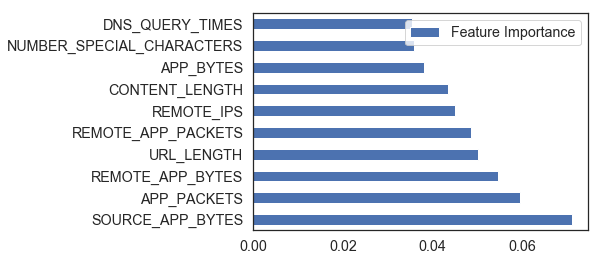

In [6]:
feat_importance = df_rf.feature_importances_
feat = pd.DataFrame({'Feature Importance': feat_importance},
            index = df_data_train.iloc[:,df_data_train.columns != 'Type'].columns)
feat.sort_values(by = 'Feature Importance', ascending = False).head(10).plot(kind = 'barh')

The base random forest classifier with 10 estimators had an accuracy of around 95%. It's most important feature was SOURCE_APP_BYTES, which is the amount of information sent between the crawler that extracted information and the webserver that hosted the site. As well, there seems to be a heavy focus on URL_LENGTH. The dissertation referenced above notes that malicious URLs, to avoid detection, often generate long random character strings. Of the top 10 most important features, half are related crawler-server communication, with two being related directly to the URL itself.

In [22]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
             }
grid_rf10 = GridSearchCV(df_rf, param_grid, cv = 10)
grid_rf5 = GridSearchCV(df_rf, param_grid, cv = 5)
grid_rf10.fit(df_data_train.iloc[:,df_data_train.columns != 'Type'], df_data_train.Type)
grid_rf5.fit(df_data_train.iloc[:,df_data_train.columns != 'Type'], df_data_train.Type)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
grid_rf10.best_params_

{'max_depth': 9, 'n_estimators': 25}

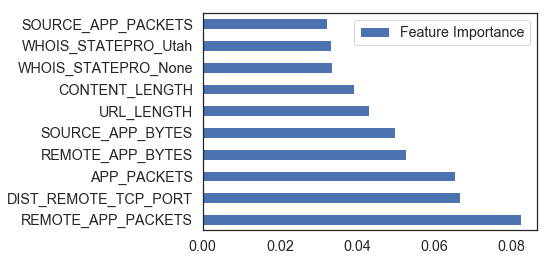

In [19]:
feat_importance = grid_rf10.best_estimator_.feature_importances_
feat = pd.DataFrame({'Feature Importance': feat_importance},
            index = df_data_train.iloc[:,df_data_train.columns != 'Type'].columns)
feat.sort_values(by = 'Feature Importance', ascending = False).head(10).plot(kind = 'barh')

In [11]:
grid_rf5.best_params_

{'max_depth': 9, 'n_estimators': 10}

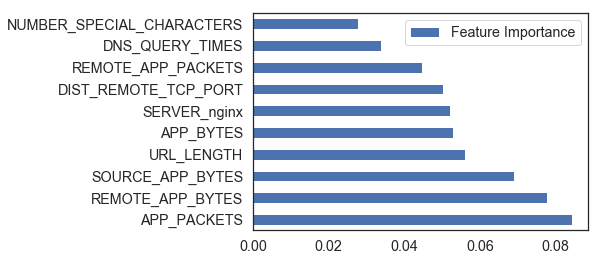

In [23]:
feat_importance = grid_rf5.best_estimator_.feature_importances_
feat = pd.DataFrame({'Feature Importance': feat_importance},
            index = df_data_train.iloc[:,df_data_train.columns != 'Type'].columns)
feat.sort_values(by = 'Feature Importance', ascending = False).head(10).plot(kind = 'barh')

In [14]:
pred_rf10_grid = grid_rf10.predict(df_data_test.iloc[:,df_data_test.columns != 'Type'])
df_data_score['pred_rf10_grid'] = pred_rf10_grid
skmetric.accuracy_score(df_data_score.Type, df_data_score.pred_rf10_grid)

0.9312714776632303

It is interesting to see here that the GridSearchCV with 10-fold cross validation actually performed worse than the base RFC model. Here, the number of packets sent from the remote server to the crawler is the most important feature (REMOTE_APP_PACKETS).

In [15]:
pred_rf5_grid = grid_rf5.predict(df_data_test.iloc[:,df_data_test.columns != 'Type'])
df_data_score['pred_rf5_grid'] = pred_rf5_grid
skmetric.accuracy_score(df_data_score.Type, df_data_score.pred_rf5_grid)

0.9347079037800687

GridSearchCV with a 5-fold cross validation still performed worse than the base RFC model, but did perform slightly better than the GridSearchCV with 10-fold cross validation. Here, the total number of packets sent between the server and the crawler (APP_PACKETS).

# Naive Bayes

In [24]:
df_nb_train = pd.DataFrame(df_data_train[['REMOTE_IPS']])
df_nb_test = pd.DataFrame(df_data_test[['REMOTE_IPS']])

In [36]:
pc0 = len(df_data[df_data.Type == 0])/len(df_data)
pc1 = len(df_data[df_data.Type == 1])/len(df_data)
print([pc0, pc1])

[0.890382626680455, 0.10961737331954498]


In [48]:
df_nb_noprior = sknb.GaussianNB()
df_nb_noprior.fit(df_nb_train, df_data_train.Type)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
pred_nb_noprior = df_nb_noprior.predict(df_nb_test)
df_data_score['pred_nb_noprior'] = pred_nb_noprior
skmetric.accuracy_score(df_data_score.Type, df_data_score.pred_nb_noprior)

0.9003436426116839

In [43]:
df_nb_noprior.class_prior_

array([0.88609467, 0.11390533])

In [44]:
df_nb_prior = sknb.GaussianNB(priors = (pc0, pc1))
df_nb_prior.fit(df_nb_train, df_data_train.Type)

GaussianNB(priors=(0.890382626680455, 0.10961737331954498),
      var_smoothing=1e-09)

In [45]:
pred_nb_prior = df_nb_prior.predict(df_nb_test)
df_data_score['pred_nb_prior'] = pred_nb_prior
skmetric.accuracy_score(df_data_score.Type, df_data_score.pred_nb_prior)

0.9003436426116839

Using a Gaussian Naive Bayes model without priors, our accuracy score was 90%. When adding priors based on the dataset itself, this accuracy score did not change at all. Without specifying priors, the model will automatically calculate class proportions from the training data itself. It seems there is approximately an equivalent class proportion between the raw dataset and the training set.

# Summary

The best parameters for the Random Forest Classifier had 10 estimators, and no specified maximum depth. Any attempt to specify the max depth only decreased the accuracy.  

The best parameters for the Gaussian Naive Bayes Classifier were the default parameters. Adding in the class priors had no effect on accuracy. I did not alter the variance smoothing; this is only used to 'smooth' out 0 values, since 0 values will break the model calculations.  

There was also an interesting occurrence; because I did not specify a random_state for the Random Forest Classifier initially, every time I reran the model, I would get a different accuracy score. This is because the RFC randomly picks a node to start at each time. However, when I specify a random_state, that integer is used to seed the RNG each time. Thus, after specifying the random_state, the RFC stops becoming random. This led to my accuracy scores stabilizing. This is also a possible explanation as to why the base model was better than the GridSearchCV models; had I run all with a different random_state, the models may start at a different point and give me different scores.